# Python Machine Learning hands-on  
  

Autores :  
João Ferreira (meetup: PyData Brasília)  
Fernando Melo (meetup: Machine Learning Brasília)

## Kaggle - Bike Sharing Demand
##### Predição do uso de bicicletas compartilhadas em Washington, D.C.  
https://www.kaggle.com/c/bike-sharing-demand/data  
3,251 times - 3 anos atrás  


O arquivo de dados que usaremos neste caderno tem dados de locação por data e hora por um período de dois anos(2011-2012). Para esta competição, o conjunto de treinamento é composto pelos primeiros 19 dias de cada mês, enquanto o conjunto de testes é do vigésimo dia até o final do mês.  
Você deve prever a contagem total de bicicletas alugadas durante cada hora dos dados de teste, usando apenas as informações disponíveis antes do período de locação.

## Importando Bibliotecas

In [ ]:
#%matplotlib inline
import pandas as pd
import numpy as np

## Importando arquivos

In [ ]:
df = pd.read_csv('../input/train.csv', parse_dates=[0])
test = pd.read_csv('../input/test.csv', parse_dates=[0])

In [ ]:
df.shape

In [ ]:
df.head()

Campos:  
datetime: data por hora + data e hora  
season: 1 = primavera, 2 = verão, 3 = outono, 4 = inverno  
holiday: se o dia é considerado um feriado  
workingday: se o dia não é um fim de semana nem feriado  
weather: 1: Limpo, Poucas nuvens, Pouco nublado, Pouco nublado
2: Névoa + Nublado, Névoa + nuvens quebradas, Névoa + Algumas nuvens, Névoa
3: Nevões fracos, Chuva fraca + Trovoada + Nuvens dispersas, Chuva fraca + Nuvens dispersas
4: Chuva forte + Paletes de Gelo + Trovoada + Névoa, Neve + Nevoeiro  
temp: temperatura em Celsius  
atemp: "parece" temperatura em Celsius  
humidity: umidade relativa  
windspeed: velocidade do vento  
casual: número de locações de usuários não registradas iniciadas  
registered: número de locações de usuários registrados iniciadas  
count: número de aluguéis totais  

In [ ]:
df.head()

In [ ]:
test.head()

In [ ]:
df.info()

In [ ]:
df['count'].hist(bins=20)

## Pegando o log da coluna count

In [ ]:
df['count'] = np.log(df['count'] + 1)

In [ ]:
1000 - 1100

In [ ]:
10 - 11

In [ ]:
df['count'].hist(bins=20)

## Mudando o Nome da Coluna count para rentals

In [ ]:
df.rename(columns={'count':'rentals'}, inplace=True)

## Pré-processamento dos Dados

Juntando os `DataFrames`

In [ ]:
df.shape

In [ ]:
df = df.append(test,sort=False)

In [ ]:
df.shape

Tratamento de datas

In [ ]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour

Criando a coluna `rolling_temp`

In [ ]:
df.sort_values('datetime', inplace=True)

In [ ]:
#df.temp.describe()

In [ ]:
df['rolling_temp'] = df['temp'].rolling(4, min_periods=1).mean()

In [ ]:
df['rolling_temp'].describe()

In [ ]:
df.shape

In [ ]:
df.head().T

In [ ]:
df.year.value_counts()

Separando os `DataFrames`:

In [ ]:
test = df[df['rentals'].isnull()]

In [ ]:
df = df[~df['rentals'].isnull()]

## Separandos os conjuntos de Treino e Validação

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# divide dataset de treino em treino(70%) e validação(30%)
train, valid = train_test_split(df, random_state=42)

In [ ]:
train.shape, valid.shape

In [ ]:
print("%.0f" % round((valid.shape[0]/train.shape[0])*100,1)+ '%')

## Selecionando as Colunas que Iremos Executar o Modelo

In [ ]:
removed_cols = ['rentals', 'casual', 'registered', 'datetime']

In [ ]:
feats = [c for c in df.columns if c not in removed_cols]

# Árvore de Decisão

Importa a classe `DecisionTreeRegressor` do scikit-learn (`sklearn`)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

Instancia um objeto chamado `dt` (DecisionTree) a partir de uma classe `DecisionTreeRegressor`

In [ ]:
dt = DecisionTreeRegressor(random_state=42, max_depth=2)

Treina a árvore de decisão com base nos dados de treinamento (`train[feats]`), e diz quais são as respostas (`train[rentals]`):

In [ ]:
dt.fit(train[feats], train['rentals'])

## Visualizando a Árvore de Decisão

Importa função `draw_tree` que serve para visualisarmos a árvore de decisão

In [ ]:
from fastai.structured import draw_tree

Desenha a árvore de decisão:

In [ ]:
draw_tree(dt, train[feats], precision=3, size=40)

Como funciona uma `DecisionTree`?

1. Vai coluna por coluna
2. Ordena todos os valores da coluna
3. Testa todos os splits possíveis
4. Avalia qual de todos os splits possíveis de todas as colunas gera a melhor decisão

A `Decision Tree` consegue ter uma boa performance mesmo sem One Hot Encoding porque ela pode fazer vários splits na mesma variável (ver exemplo acima onde, ocorrem dois splits seguidos na coluna `hour).

## RandomForest

A `RandomForest` é um conjunto de árvores de decisão. Essas árvores são aleatórias porque as linhas que são usadas para treiná-la são selecionadas de forma aleatória por um processo chamado de `bootstraping`.

1. Faz bootstraping (seleciona linhas de forma aleatória **com repetição**)
2. O resultado do bootstraping é que são geradas diversas árvores diferentes a partir de um processo aleatório, o que significa que não existe um padrão sistemático de geração de cada uma dessas árvores, nos permitindo a partir de vários modelos mais fracos, gerarmos um modelo robusto.


As previsões de uma `RandomForest` são a média das previsões individuais de cada árvore de decisão (`DecisionTree`)

Importando a classe `RandomForestRegressor`

In [ ]:
from sklearn.ensemble import RandomForestRegressor

Instanciando o objeto `rf` (RandomForest) a partir da classe `RandomForestRegressor`

In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

Treinando o modelo com os dados de treino

In [ ]:
rf.fit(train[feats], train['rentals'])

Fazendo as previsões nos dados de validação

In [ ]:
preds = rf.predict(valid[feats])

Importando a função `mean_squared_error` para avaliar o desempenho do nosso modelo

In [ ]:
from sklearn.metrics import mean_squared_error

Avaliando o desempenho do nosso modelo nos dados de validação

In [ ]:
mean_squared_error(valid['rentals'], preds)**(1/2)

Fazendo previsões nos dados de teste

In [ ]:
train_preds = rf.predict(train[feats])

Avaliando o desempenho do nosso modelo nos dados de treino

In [ ]:
mean_squared_error(train['rentals'], train_preds)**(1/2)

Gerando o output do modelo:

In [ ]:
test['count'] = np.exp(rf.predict(test[feats]))

In [ ]:
test[['datetime', 'count']].to_csv('rf.csv', index=False)

score: 0.45578

## Otimizando uma RandomForest

Os principais parâmetros que usamos para otimizar uma `RandomForest` são:
    1. `max_depth` - Seleciona a profundidade das árvores, isto é, o número máximo de splits que ele vai fazer em sequência.
    2. `min_samples_leaf` - Seleciona o número mínimo de amostrar em uma folha necessários para que possamos fazer mais um split nessa folha
    3. `max_features` - Seleciona o percentual de colunas que serão avaliadas como uma opção válida[](http://) em cada split

Instancia uma nova `RandomForest`

In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=200)

Treina a nova `RandomForest`

In [ ]:
rf.fit(train[feats], train['rentals'])

Gera as previsões no conjunto de validação:

In [ ]:
preds = rf.predict(valid[feats])

Avalia a métrica das previsões geradas no conjunto de validação:

In [ ]:
mean_squared_error(valid['rentals'], preds)**(1/2)

Gera as previsões no conjunto de treino:

In [ ]:
train_preds = rf.predict(train[feats])

Avalia a métrica das previsões geradas no conjunto de treino:

In [ ]:
mean_squared_error(train['rentals'], train_preds)**(1/2)

In [ ]:
test['count'] = np.exp(rf.predict(test[feats]))

In [ ]:
test[['datetime', 'count']].to_csv('rf_opt.csv', index=False)

score: 0.44036

## Validação Usando OOB

As previsões `OOB` (Out of Bag) são computadas árvore a árvore usando as linhas que não foram selecionadas para montar determinada árvore em uma `DecisionTree` (lembre-se que as linhas são selecionadas aleatoriamente com repetição, então em média 37% das linhas ficam fora de cada árvore de decisão).

Para que a nossa `RandomForest` faça previsões `OOB` precisamos passar o parâmetro `oob_score=True` na hora que a instanciamos.

Instancia uma nova `RandomForest`:

In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=200, oob_score=True)

Faz um fit usando todos os dados (`df`) e não apenas os dados que tinham sido selecionados como treino (`train`):

In [ ]:
rf.fit(df[feats], df['rentals'])

Avalia a métrica da competição em todos os dados a partir das previsões `OOB`:

In [ ]:
mean_squared_error(df['rentals'], rf.oob_prediction_)**(1/2)


## R² Score

O R² é uma métrica que já está incorporada no quando usamos o parâmetro `oob_score=True`. Para acessá-la basta usarmos o comando abaixo:********

In [ ]:
rf.oob_score_

Esse comando é equivalente a usarmos o `r2_score` implementado pelo `sklearn`:

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(df['rentals'], rf.oob_prediction_)

Um R² de `1.0` significa que nosso modelo está perfeito:

In [ ]:
r2_score(df['rentals'], df['rentals'])

Um R² de `0.0` significa que nosso modelo está tão bom quanto um modelo que prevê a média:

In [ ]:
r2_score(df['rentals'], np.full(rf.oob_prediction_.shape[0], df['rentals'].mean()))

Um R² negativo significa que nosso modelo é pior do que um modelo que prevê a média (o R² pode ser inclusive extremamente negativo):

In [ ]:
r2_score(df['rentals'], np.full(rf.oob_prediction_.shape[0], 10000))

**Prepara arquivo para Envio(submissão)**

In [ ]:
test['count'] = np.exp(rf.predict(test[feats]))

In [ ]:
test[['datetime', 'count']].to_csv('rf_full.csv', index=False)

**Faça Submissão das suas predições para a competição no Kaggle**  
Primeiro você precisa dar commit no seu kernel(caderno jupyter).  
Você precisa tornar o seu kernel "Public".  
    Clique no botão Publicar azul no topo da tela do seu kernel. Levará algum tempo para o seu kernel rodar. Quando terminar, sua barra de navegação na parte superior da tela terá uma guia para Saída(Output). Isso só aparece se você tiver escrito um arquivo de saída (como fizemos na etapa Preparar Arquivo para Envio).

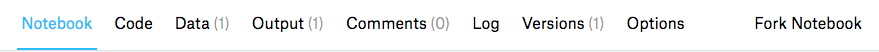

Últimos passos  
Clique no botão Output. Isso levará você a uma tela com uma opção para enviar para a competição.   
Acertar isso e você verá como o seu modelo se comportou.
Eventualmente, caso a competição já esteja encerrada, seu nome não aparecer no Public Leaderboard.
O Private Leaderboard só ficará disponível , assim que a competição encerrar.
Se você quiser voltar para melhorar seu modelo, clique no botão Editar, que reabre o kernel.   
Você precisará executar novamente todas as células ao reabrir o kernel.

score: 0.43718

In [ ]:
# Calcula a posição relativa no Kaggle Public Leaderboard
729/3251

In [ ]:
# POSIÇÃO: 729 , TOP 22% da competição.

In [ ]:
#-----------------------------------------------------------------------------------------------------------------------

## Criando um Set de Validação Melhor

In [ ]:
train.shape , valid.shape

In [ ]:
train, valid = df[df['day'] <= 15], df[df['day'] > 15]

In [ ]:
train.shape , valid.shape

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=200, min_samples_split=4, max_features=0.9, max_depth=17, oob_score=True)

In [ ]:
rf.fit(train[feats], train['rentals'])

In [ ]:
preds = rf.predict(valid[feats])

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(valid['rentals'], preds)**(1/2)

## Removendo a Coluna Day

In [ ]:
feats = [c for c in feats if c not in ['day']]

## Testando sem a Coluna Day

In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=200, min_samples_split=4, max_features=0.9, max_depth=17, oob_score=True)

In [ ]:
rf.fit(df[feats], df['rentals'])

In [ ]:
preds = rf.predict(df[feats])

In [ ]:
mean_squared_error(df['rentals'], rf.oob_prediction_)**(1/2)

In [ ]:
train_preds = rf.predict(df[feats])

In [ ]:
mean_squared_error(df['rentals'], train_preds)**(1/2)

## Fazer predições com o dataset inteiro

In [ ]:
rf.predict(test[feats])

In [ ]:
test['count'] = np.exp(rf.predict(test[feats]))

In [ ]:
test[['datetime', 'count']].to_csv('rf_full_wo_day.csv', index=False)

## Testando sem a Coluna Month

In [ ]:
feats = [c for c in feats if c not in ['month', 'holiday']]

In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=200, min_samples_split=4, max_features=0.9, max_depth=17, oob_score=True)

In [ ]:
rf.fit(df[feats], df['rentals'])

In [ ]:
preds = rf.predict(df[feats])

In [ ]:
mean_squared_error(df['rentals'], rf.oob_prediction_)**(1/2)

In [ ]:
train_preds = rf.predict(df[feats])

In [ ]:
mean_squared_error(df['rentals'], train_preds)**(1/2)

Fazer predições com o dataset inteiro

In [ ]:
rf.predict(test[feats])

In [ ]:
test['count'] = np.exp(rf.predict(test[feats]))

In [ ]:
test[['datetime', 'count']].to_csv('rf_full_wo_month.csv', index=False)

## Validação Cruzada

In [ ]:
def cv(df, test, k, feats, y_name):
    preds, score, fis = [], [], []
    
    chunk = df.shape[0] // k
    for i in range(k):
        if i + 1 < k:
            valid = df.iloc[i*chunk: (i+1)*chunk]
            train = df.iloc[: i*chunk].append(df.iloc[(i+1)*chunk:])
            
        else:
            valid = df.iloc[i*chunk:]
            train = df.iloc[: i*chunk] 

        rf = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=200, min_samples_split=4, max_features=0.9, max_depth=17, oob_score=True)
        
        rf.fit(train[feats], train[y_name])
        
        score.append(mean_squared_error(valid[y_name], rf.predict(valid[feats]))**(1/2))  
        
        preds.append(rf.predict(test[feats]))  
        
        fis.append(rf.feature_importances_)
        
        print(i, 'OK')
    return pd.Series(score), pd.Series(preds).mean(), fis

In [ ]:
score, preds, fis = cv(df, test, 20, feats, 'rentals')

In [ ]:
score.mean()

In [ ]:
test['count'] = np.exp(preds)

In [ ]:
test[['datetime', 'count']].to_csv('rf_cv_wo_day.csv', index=False)

## Cross Validation Feature Importance

In [ ]:
fi = pd.Series(pd.DataFrame(fis).mean().values, index=feats)

In [ ]:
fi.sort_values().plot.barh(figsize=(20,10))

## Rodando o Modelo Sem a Coluna Holiday

In [ ]:
feats = [c for c in feats if c not in ['holiday']]

In [ ]:
score, preds, fis = cv(df, test, 20, feats, 'rentals')

In [ ]:
score.mean()

In [ ]:
test['count'] = np.exp(preds)

In [ ]:
test[['datetime', 'count']].to_csv('rf_cv_wo_holiday.csv', index=False)

**FIM**